In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from codecarbon import EmissionsTracker
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import shap
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

c:\Users\janse\Playground\final_project_AM\extreme-waether-forecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Check the device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Additional GPU information
if torch.cuda.is_available():
    print(f"CUDA is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    
    # Clear GPU cache
    torch.cuda.empty_cache()
    
    # Set memory allocation strategy (optional)
    torch.cuda.set_per_process_memory_fraction(0.5)  # Use 50% of GPU memory
else:
    print("CUDA is not available. Using CPU.")

device

Using device: cuda
CUDA is available!
GPU Name: NVIDIA GeForce RTX 2050
GPU Memory: 4.3 GB
Number of GPUs: 1
Current GPU: 0


device(type='cuda')

In [2]:
df = pd.read_csv('data/all_data.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414829 entries, 0 to 414828
Data columns (total 18 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       414829 non-null  float64
 1   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  414829 non-null  float64
 2   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        414829 non-null  float64
 3   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       414829 non-null  float64
 4   RADIACAO GLOBAL (Kj/m²)                                414829 non-null  float64
 5   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           414829 non-null  float64
 6   TEMPERATURA DO PONTO DE ORVALHO (°C)                   414829 non-null  float64
 7   TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)             414829 non-null  float64
 8   TEMPERATURA MÍNIMA NA HORA ANT. (A

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

input_data = df.drop([
    'datetime',
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'], axis=1)
targets = df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].values
T = 20                   
D = input_data.shape[1] 
N = len(input_data) - T

In [4]:
#Train size: 80% of the total data size
train_size = int(len(input_data) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data = scaler.transform(input_data)

# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
  X_train[t, :, :] = input_data[t:t+T]
  y_train[t] = (targets[t+T])

# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = input_data[t:t+T]
  y_test[i] = (targets[t+T])

# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [5]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    device = X.device  # Use the same device as input
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

In [52]:
model = LSTM(input_dim=D, hidden_dim=256, layer_dim=2, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [53]:
def train(model, learning_rate, X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{epochs}] — Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, test_losses

In [6]:
def return_rmse(model, X_test, y_test, batch_size=32):
    model.eval()
    device = next(model.parameters()).device
    
    # Clear GPU cache first
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Process in batches to avoid OOM
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()  # Move back to CPU immediately
            predictions.append(batch_pred)
            
            # Clear cache after each batch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Concatenate all predictions
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    return rmse

In [55]:
tracker = EmissionsTracker(
    project_name="PRECIPTATION lstm",
    output_file='codecarbon-lstm/codecarbon_emissions_prec.csv',
    log_level = "critical"
)

tracker.start()

train_losses, test_losses = train(
    model,
    learning_rate=0.01,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    epochs=25,
    batch_size=64
)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Epoch [1/25] — Train Loss: 1.1899, Test Loss: 1.4622


Epoch [2/25] — Train Loss: 1.1907, Test Loss: 1.6586


Epoch [3/25] — Train Loss: 1.1912, Test Loss: 1.4742


Epoch [4/25] — Train Loss: 1.1566, Test Loss: 1.4450


Epoch [5/25] — Train Loss: 1.1556, Test Loss: 1.4896


Epoch [6/25] — Train Loss: 1.1508, Test Loss: 1.5093


Epoch [7/25] — Train Loss: 1.1579, Test Loss: 1.4551


Epoch [8/25] — Train Loss: 1.1547, Test Loss: 1.4528


Epoch [9/25] — Train Loss: 1.1517, Test Loss: 1.5216


Epoch [10/25] — Train Loss: 1.1460, Test Loss: 1.5111


Epoch [11/25] — Train Loss: 1.1459, Test Loss: 1.4474


Epoch [12/25] — Train Loss: 1.1575, Test Loss: 1.4893


Epoch [13/25] — Train Loss: 1.1532, Test Loss: 1.4366


Epoch [14/25] — Train Loss: 1.1452, Test Loss: 1.5115


Epoch [15/25] — Train Loss: 1.1515, Test Loss: 1.4281


Epoch [16/25] — Train Loss: 1.1555, Test Loss: 1.4424


Epoch [17/25] — Train Loss: 1.1570, Test Loss: 1.4389


Epoch [18/25] — Train Loss: 1.1589, Test Loss: 1.4244


Epoch [19/25] — Train Loss: 1.1543, Test Loss: 1.4419


Epoch [20/25] — Train Loss: 1.1579, Test Loss: 1.4477


Epoch [21/25] — Train Loss: 1.1545, Test Loss: 1.4486


Epoch [22/25] — Train Loss: 1.1481, Test Loss: 1.4752


Epoch [23/25] — Train Loss: 1.1574, Test Loss: 1.5178


Epoch [24/25] — Train Loss: 1.1565, Test Loss: 1.4416


Epoch [25/25] — Train Loss: 1.1563, Test Loss: 1.4388
emissions=0.0022127860026204356


In [ ]:
# Export the model as a pkl file
torch.save(model.state_dict(), 'lstm_precipitation_model.pth')

In [10]:
# Carrega o modelo salvo, para evitar recriação
model = LSTM(input_dim=D, hidden_dim=256, layer_dim=2, output_dim=1)
model.load_state_dict(torch.load('lstm_precipitation_model.pth', weights_only=True))
model = model.to(device)

model.eval()

print("Model loaded successfully and moved to device:", device)

Model loaded successfully and moved to device: cuda


In [14]:
def plot_dispersion(model, X_test, y_test, batch_size=32):
    model.eval()
    device = next(model.parameters()).device  # Get the model's device (CPU or CUDA)
    
    # Clear GPU cache first
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Process in batches to avoid OOM
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()  # Move back to CPU immediately
            predictions.append(batch_pred)
            
            # Clear cache after each batch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Concatenate all predictions
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    mae = mean_absolute_error(y_true_np, y_pred_np)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true_np, y_pred_np, alpha=0.6, color='blue', s=20)
    plt.xlabel('True Values (mm)', fontsize=12)
    plt.ylabel('Predicted Values (mm)', fontsize=12)
    plt.title(f'Precipitation LSTM: True vs Predicted\nRMSE: {rmse:.4f}, MAE: {mae:.4f}', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Ideal line (perfect prediction)
    min_val = min(y_true_np.min(), y_pred_np.min())
    max_val = max(y_true_np.max(), y_pred_np.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('./plots/lstm_prec_dispersion.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Dispersion Plot Metrics:")
    print(f"   RMSE: {rmse:.4f} mm")
    print(f"   MAE: {mae:.4f} mm")
    print(f"   Samples plotted: {len(y_true_np)}")

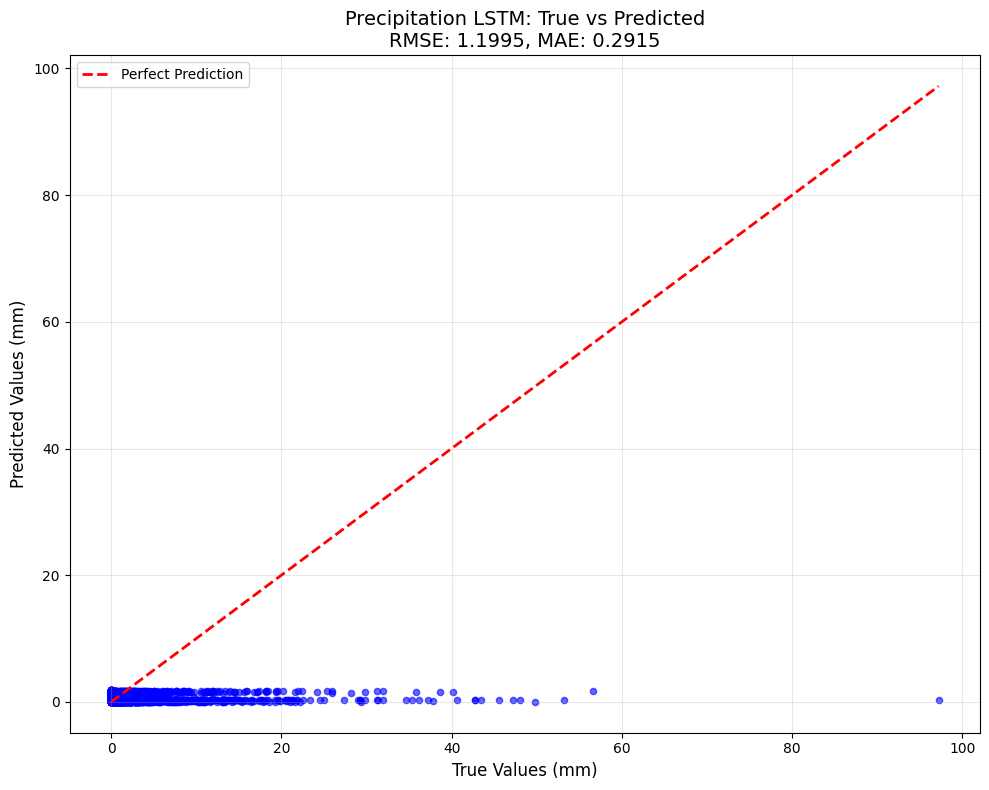

📊 Dispersion Plot Metrics:
   RMSE: 1.1995 mm
   MAE: 0.2915 mm
   Samples plotted: 82946


In [15]:
plot_dispersion(model, X_test, y_test)

In [23]:
# Limpar memória GPU antes de executar funções de plot
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU Memory before plotting: {torch.cuda.memory_allocated()/1e9:.2f} GB")
    print(f"GPU Memory cached: {torch.cuda.memory_reserved()/1e9:.2f} GB")
    print("GPU cache cleared!")

GPU Memory before plotting: 0.03 GB
GPU Memory cached: 0.04 GB
GPU cache cleared!


In [ ]:
def plot_real_vs_predicted(model, X_test, y_test, batch_size=32, sample_limit=1000):
    model.eval()
    device = next(model.parameters()).device  # Automatically get the model's device
    
    # Clear GPU cache first
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Process in batches to avoid OOM
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()  # Move back to CPU immediately
            predictions.append(batch_pred)
            
            # Clear cache after each batch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Concatenate all predictions
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    # Limit samples for better visualization
    if len(y_true_np) > sample_limit:
        indices = np.linspace(0, len(y_true_np)-1, sample_limit, dtype=int)
        y_true_plot = y_true_np[indices]
        y_pred_plot = y_pred_np[indices]
        print(f"📊 Plotting {sample_limit} samples out of {len(y_true_np)} for better visualization")
    else:
        y_true_plot = y_true_np
        y_pred_plot = y_pred_np

    # Calculate metrics on full dataset
    rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    mae = mean_absolute_error(y_true_np, y_pred_np)

    # Plot real vs predicted
    plt.figure(figsize=(14, 6))
    plt.plot(y_true_plot, label='Real', linewidth=1.5, alpha=0.8, color='blue')
    plt.plot(y_pred_plot, label='Predicted', linewidth=1.5, alpha=0.8, color='orange')
    plt.title(f'Precipitation LSTM: Real vs Predicted Values\nRMSE: {rmse:.4f} mm, MAE: {mae:.4f} mm', fontsize=14)
    plt.xlabel('Sample Index', fontsize=12)
    plt.ylabel('Precipitation (mm)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('./plots/lstm_prec_real_x_pred.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📈 Model Performance Metrics:")
    print(f"   RMSE: {rmse:.4f} mm")
    print(f"   MAE: {mae:.4f} mm")
    print(f"   Total test samples: {len(y_true_np)}")

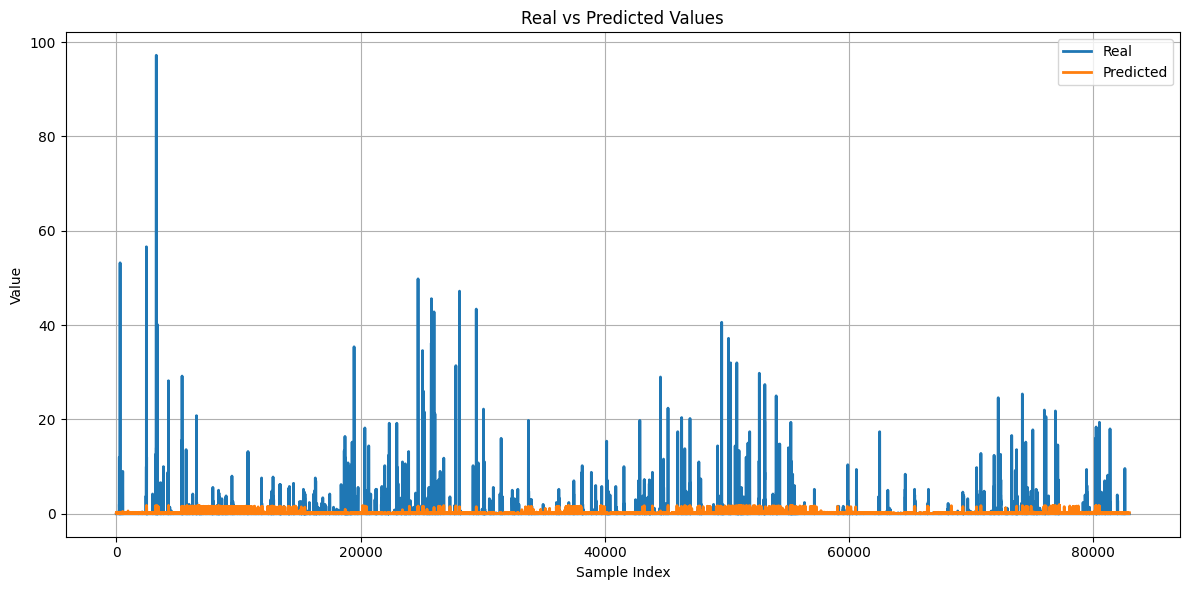

In [61]:
plot_real_vs_predicted(model, X_test, y_test)

In [ ]:
def print_rmse(model, X_test, y_test, batch_size=32):
    model.eval()
    device = next(model.parameters()).device
    
    # Clear GPU cache first
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Process in batches to avoid OOM
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()  # Move back to CPU immediately
            predictions.append(batch_pred)
            
            # Clear cache after each batch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Concatenate all predictions
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    # Calculate comprehensive metrics
    rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    mae = mean_absolute_error(y_true_np, y_pred_np)
    mse = mean_squared_error(y_true_np, y_pred_np)
    
    # Additional statistics
    correlation = np.corrcoef(y_true_np, y_pred_np)[0,1]
    
    print(f"📊 PRECIPITATION LSTM MODEL EVALUATION:")
    print(f"   RMSE: {rmse:.4f} mm")
    print(f"   MAE:  {mae:.4f} mm") 
    print(f"   MSE:  {mse:.4f} mm²")
    print(f"   Correlation: {correlation:.4f}")
    print(f"   Test samples: {len(y_true_np)}")
    
    # Statistics about predictions vs actual
    print(f"\n📈 DATA STATISTICS:")
    print(f"   True values  - Mean: {np.mean(y_true_np):.4f}, Std: {np.std(y_true_np):.4f}")
    print(f"   Predictions  - Mean: {np.mean(y_pred_np):.4f}, Std: {np.std(y_pred_np):.4f}")
    print(f"   Max true:    {np.max(y_true_np):.4f} mm")
    print(f"   Max pred:    {np.max(y_pred_np):.4f} mm")

In [63]:
print_rmse(model, X_test, y_test)

RMSE: 1.1995


In [64]:
def plot_lstm_prediction_over_time(model, X_test, y_test, timestamps, start_date=None, end_date=None, save=False, batch_size=32):
    model.eval()
    device = next(model.parameters()).device

    # Clear GPU cache first
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Process in batches to avoid OOM
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()  # Move back to CPU immediately
            predictions.append(batch_pred)
            
            # Clear cache after each batch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Concatenate all predictions
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()
    timestamps = pd.to_datetime(timestamps)

    data = pd.DataFrame({
        'Timestamp': timestamps,
        'Actual': y_true_np,
        'Predicted': y_pred_np
    })

    if start_date:
        data = data[data['Timestamp'] >= pd.to_datetime(start_date)]
    if end_date:
        data = data[data['Timestamp'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(data['Timestamp'], data['Actual'], label='Actual Values', color='blue', linewidth=2)
    plt.plot(data['Timestamp'], data['Predicted'], label='Predicted Values', color='orange', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('LSTM: Actual vs. Predicted Values Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(save)

    plt.show()

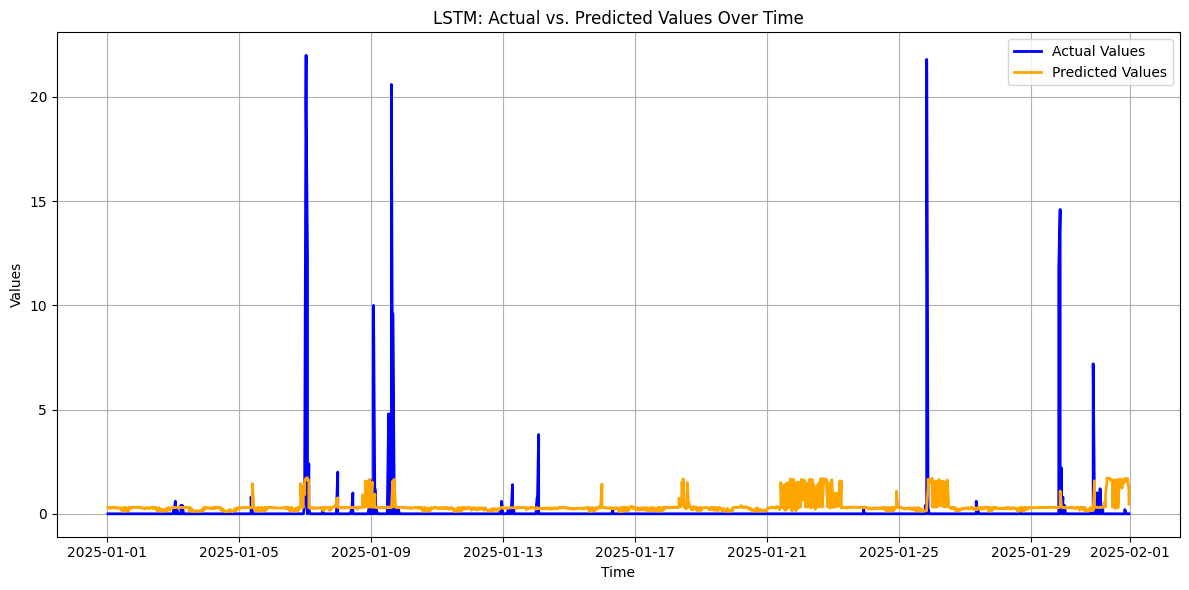

In [65]:
start_date = "2025-01-01 01:00:00"
end_date = "2025-01-31 23:00:00"

timestamps = pd.to_datetime(df['datetime'])
timestamps_for_plot = timestamps[T:T + N]
timestamps_test = timestamps_for_plot[train_size:]

plot_lstm_prediction_over_time(model, X_test, y_test, timestamps_test,start_date, end_date, save='./plots/lstm_prec_rvp.png')

In [12]:
import shap
import gc
import numpy as np

# Configuração ultra-conservadora para GPU 4GB
num_background_samples = 100  # Reduzido para precipitação
num_test_samples = 100 
max_batch_size = 5  # Micro-batches para GPU
nsamples = 100  # Configuração conservadora

# Limpar cache da GPU antes de começar
torch.cuda.empty_cache()
gc.collect()

print("CONFIGURAÇÃO SHAP - PRECIPITATION LSTM:")
print(f"   Background samples: {num_background_samples}")
print(f"   Test samples: {num_test_samples}")
print(f"   Max batch size: {max_batch_size}")
print(f"   SHAP nsamples: {nsamples}")

# Preparar dados para SHAP
background_data = X_train[:num_background_samples].cpu().numpy()
test_data = X_test[:num_test_samples].cpu().numpy()

# Converter para formato flat (SHAP requer)
background_flat = background_data.reshape(background_data.shape[0], -1)
test_flat = test_data.reshape(test_data.shape[0], -1)

print(f"   Background shape: {background_flat.shape}")
print(f"   Test shape: {test_flat.shape}")

def lstm_predict_wrapper_precipitation(X_flat):
    """
    Wrapper ultra-conservador para LSTM Precipitation
    """
    if len(X_flat.shape) == 1:
        X_flat = X_flat.reshape(1, -1)
    
    # Converter para formato 3D (batch, time, features)
    batch_size = X_flat.shape[0]
    X_3d = X_flat.reshape(batch_size, T, D)
    
    predictions = []
    
    # Processar em micro-batches
    for i in range(0, batch_size, max_batch_size):
        torch.cuda.empty_cache()  # Limpar cache
        
        end_idx = min(i + max_batch_size, batch_size)
        batch_3d = X_3d[i:end_idx]
        
        X_tensor = torch.from_numpy(batch_3d.astype(np.float32)).to(device)
        
        model.eval()  # Modo avaliação
        with torch.no_grad():
            batch_pred = model(X_tensor).cpu().numpy()
            predictions.append(batch_pred)
        
        del X_tensor
    
    all_predictions = np.concatenate(predictions, axis=0)
    torch.cuda.empty_cache()
    
    return all_predictions.flatten()

print("Creating SHAP KernelExplainer...")
explainer = shap.KernelExplainer(lstm_predict_wrapper_precipitation, background_flat)

print("Computing SHAP values...")
shap_values = explainer.shap_values(test_flat, nsamples=nsamples)

print(f"SHAP values shape: {shap_values.shape}")

# Verificações de integridade
expected_samples = num_test_samples
actual_samples = shap_values.shape[0]
print(f"Amostras esperadas: {expected_samples}")
print(f"Amostras analisadas: {actual_samples}")

nan_count = np.isnan(shap_values).sum()
inf_count = np.isinf(shap_values).sum()
print(f"Valores NaN: {nan_count}")
print(f"Valores Inf: {inf_count}")

# Estatísticas básicas
for i in range(min(3, actual_samples)):
    sample_sum = np.sum(shap_values[i])
    sample_abs_sum = np.sum(np.abs(shap_values[i]))
    print(f"Amostra {i}: Soma SHAP = {sample_sum:.6f}, Soma absoluta = {sample_abs_sum:.6f}")

# Limpar memória final
torch.cuda.empty_cache()
gc.collect()

CONFIGURAÇÃO SHAP - PRECIPITATION LSTM:
   Background samples: 100
   Test samples: 100
   Max batch size: 5
   SHAP nsamples: 100
   Background shape: (100, 440)
   Test shape: (100, 440)
Creating SHAP KernelExplainer...
Computing SHAP values...


 12%|█▏        | 12/100 [00:47<05:33,  3.79s/it]c:\Users\janse\Playground\final_project_AM\extreme-waether-forecasting\.venv\Lib\site-packages\shap\explainers\_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
 19%|█▉        | 19/100 [01:12<04:59,  3.70s/it]c:\Users\janse\Playground\final_project_AM\extreme-waether-forecasting\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.620e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or inc

SHAP values shape: (100, 440)
Amostras esperadas: 100
Amostras analisadas: 100
Valores NaN: 0
Valores Inf: 0
Amostra 0: Soma SHAP = 0.010132, Soma absoluta = 0.072618
Amostra 1: Soma SHAP = 0.003469, Soma absoluta = 0.116877
Amostra 2: Soma SHAP = 0.002582, Soma absoluta = 0.039166


0

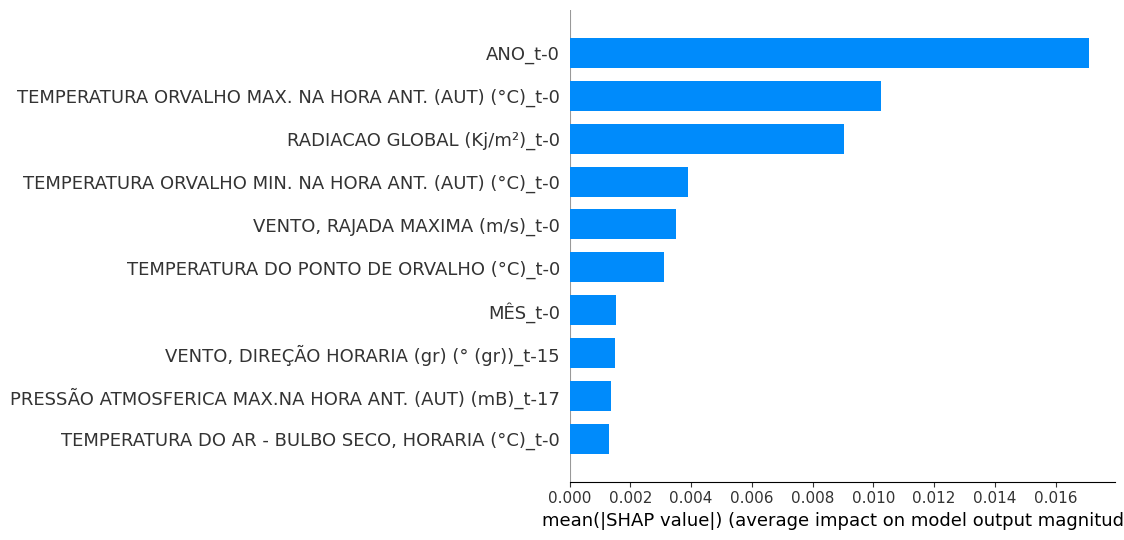

In [13]:
base_features = [
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
    'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)', 
    'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
    'RADIACAO GLOBAL (Kj/m²)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'TEMPERATURA DO PONTO DE ORVALHO (°C)',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)', 
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'VENTO, DIREÇÃO HORARIA (gr) (° (gr))',
    'VENTO, RAJADA MAXIMA (m/s)',
    'VENTO, VELOCIDADE HORARIA (m/s)',
    'ANO', 'MÊS', 'DIA', 'HORA', 'MINUTO', 'SEGUNDO'
]

feature_names_lstm = []
for t in range(T-1, -1, -1):  # t-19 to t-0
    for feature in base_features:
        if t == 0:
            feature_names_lstm.append(f"{feature}_t-{t}")
        else:
            feature_names_lstm.append(f"{feature}_t-{t}")

# Create a larger figure with better layout
plt.figure(figsize=(12, 8))

shap.summary_plot(
    shap_values, 
    features=test_flat, 
    feature_names=feature_names_lstm, 
    plot_type="bar", 
    max_display=10,
    show=False
)
plt.tight_layout()
plt.subplots_adjust(left=0.3)  # Make room for long feature names
plt.savefig('./plots/lstm_prec_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()